### Attacking VGG trained on CIFAR10

In this notebook we aim to perform an adversarial attack against a black-box model trained on *Cifar10* 

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
cd /content/gdrive/My Drive/Colab Notebooks/AdvAttack

/content/gdrive/My Drive/Colab Notebooks/AdvAttack


**Import packages**

In [10]:
import src.loss as customLoss
import src.ZOOptim as ZOOptim
import src.dataset as data

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tqdm import tqdm


import torch
from torch import nn, optim
from torchvision import transforms
from src.models import MyVGG

**Retrieve CIFAR10 data**

We retrieve the CIFAR10 data. <br>
We use the *standard* option to retrieve the unnormalized and unchanged data. 

Files already downloaded and verified
Files already downloaded and verified

Batch is a <class 'list'>
The 1st element is a <class 'torch.Tensor'> with shape torch.Size([32, 3, 32, 32])
The 2nd element is a <class 'torch.Tensor'> with shape torch.Size([32])


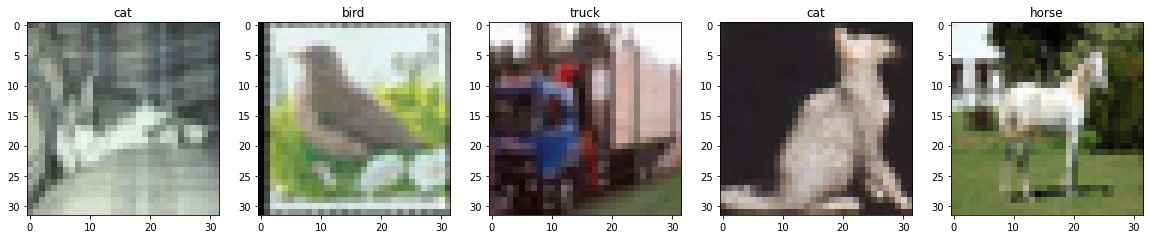

In [4]:
DataLoader = data.CIFAR10(transform='standard')
train, test = DataLoader.get_dataloader(batch_size=32, num_workers=0)
DataLoader.get_info()

In [5]:
device = torch.device('cuda')
net = MyVGG().to(device)
net.load_state_dict(torch.load('models/VGG16_cifar10_state_dict.pth'))

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth


<All keys matched successfully>

In [6]:
for batch in test:
    X, y = batch[0].to(device), batch[1].to(device)

In [7]:
out = net(X)
y_pred = torch.argmax(out, axis=1)
match = y_pred - y.to(device)
TP = match[match == 0].shape[0]
print('Accuracy is {:.2f}'.format(TP/X.shape[0]))

Accuracy is 0.75


### MAIN
**5. ADVERSARIAL ATTACK**

Here we try to start with a random rightfully classified image from the validation set and we try to use *Zero-order Stochastic Coordinate descent with Coordinate-wise ADAM/Newton* to modify the image in order to make the network be mistaken.

We can choose whetever to use ADAM or Newton's Method by setting the solver parameter


**Args:**

        Name            Type                Description
        
        x:              (torch.tensor)      The variable of our optimization problem. Should be a 3D tensor (img)
        c:              (float)             Loss weight
        learning_rate:  (float)             Learning rate
        batch_size:     (int)               Coordinates we simultaneously optimize
        h:              (float)             Used in gradient approximation
        beta_1:         (float)             ADAM hyper-parameter
        beta_2:         (float)             ADAM hyper-parameter
        msolver:        (str)               ADAM or Newton
        epsilon:        (float)             Avoid divide by 0
        max_iterations: (int)               The maximum number of steps
        stop_criterion: (bool)              Stop when the loss is zero and the l2 distance doesn't decrease for 20 steps
        verbose:        (int)               Display information or not. Default is 0
        additional_out  (bool)              Return also all the x. Default is False
        tqdm_disable    (bool)              Disable the tqdm bar. Default is False



**Suggested values** <br>
*ZOO: Zeroth Order Optimization Based Black-box Attacks to
Deep Neural Networks without Training Substitute Models* (Chen, Zhang et al.):

* learning_rate = 0.001 
* batch_size = 128
* h = 0.0001
* beta_1 = 0.9
* beta_2 = 0.999
* solver = "adam"
* max_iterations = 10000

All this parameters are initialized by default. 

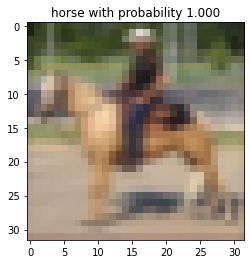

In [8]:
net.eval()
img = X[0].cpu().numpy()
out = nn.Softmax(dim=1)(net(X[0].reshape(1, *list(img.shape))))
plt.imshow(np.transpose(img, (1, 2, 0)))
original_label = torch.argmax(out).item()
plt.title('{} with probability {:.3f}'.format(DataLoader.classes[original_label], float(out[0, original_label])))
plt.show()

**5.1 General attack**

Here we try to manipulate the input such that it will be misclassified in favor of a whatever class. Usually its easier and we deal with the problem by minimizing the probability of the true class  

*E.g.* <br> 
We want to try to minimize the probability of classification of neuron *zero*

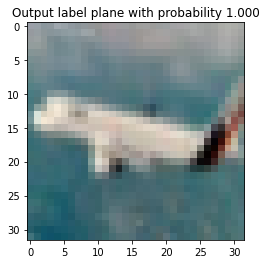

In [9]:
# 1. Choose image
index = 3

# 2. Define params
#solver = "adam"
solver = "newton"

params = {'x': X[index], 'c': 0.3, 'learning_rate': 1e-2, 
          'n_gradient': 128, 'solver': solver, 'max_steps': 1000, 
          'verbose': 0, 'stop_criterion': True, 'additional_out': True}

net.eval()
img_orig = X[index].cpu().numpy()
out_orig = nn.Softmax(dim=1)(net(X[index].reshape(1, *list(img.shape))))
plt.imshow(np.transpose(img_orig, (1, 2, 0)))
original_label = torch.argmax(out_orig).item()
plt.title('Output label {} with probability {:.3f}'.format(DataLoader.classes[original_label], float(out_orig[0, original_label])))
plt.show()



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<03:11,  5.22it/s]

  0%|          | 2/1000 [00:00<03:09,  5.25it/s]

  0%|          | 3/1000 [00:00<03:02,  5.45it/s]

  0%|          | 4/1000 [00:00<02:55,  5.69it/s]

  0%|          | 5/1000 [00:00<02:47,  5.95it/s]

  1%|          | 6/1000 [00:01<02:41,  6.15it/s]

  1%|          | 7/1000 [00:01<02:37,  6.30it/s]

  1%|          | 8/1000 [00:01<02:36,  6.35it/s]

  1%|          | 9/1000 [00:01<02:34,  6.41it/s]

  1%|          | 10/1000 [00:01<02:32,  6.49it/s]

  1%|          | 11/1000 [00:01<02:31,  6.52it/s]

  1%|          | 12/1000 [00:01<02:31,  6.53it/s]

  1%|▏         | 13/1000 [00:02<02:30,  6.56it/s]

  1%|▏         | 14/1000 [00:02<02:29,  6.60it/s]

  2%|▏         | 15/1000 [00:02<02:28,  6.63it/s]

  2%|▏         | 16/1000 [00:02<02:29,  6.60it/s]

  2%|▏         | 17/1000 [00:02<02:29,  6.57it/s]

  2%|▏         | 18/1000 [00:02<02:29,  6.55it/s]

  2%|▏         | 19/1000 [00:02<02:29,  6.57it/

First valid image found at iteration 176 with l2-distance = 0.21173058450222015




 18%|█▊        | 179/1000 [00:27<02:05,  6.57it/s]

 18%|█▊        | 180/1000 [00:27<02:05,  6.52it/s]

 18%|█▊        | 181/1000 [00:27<02:05,  6.51it/s]

 18%|█▊        | 182/1000 [00:27<02:05,  6.54it/s]

 18%|█▊        | 183/1000 [00:27<02:05,  6.50it/s]

 18%|█▊        | 184/1000 [00:27<02:05,  6.49it/s]

 18%|█▊        | 185/1000 [00:28<02:05,  6.47it/s]

 19%|█▊        | 186/1000 [00:28<02:05,  6.50it/s]

 19%|█▊        | 187/1000 [00:28<02:04,  6.52it/s]

 19%|█▉        | 188/1000 [00:28<02:04,  6.54it/s]

 19%|█▉        | 189/1000 [00:28<02:03,  6.56it/s]

 19%|█▉        | 190/1000 [00:28<02:03,  6.55it/s]

 19%|█▉        | 191/1000 [00:29<02:03,  6.53it/s]

 19%|█▉        | 192/1000 [00:29<02:03,  6.52it/s]

 19%|█▉        | 193/1000 [00:29<02:04,  6.51it/s]

 19%|█▉        | 194/1000 [00:29<02:02,  6.56it/s]

 20%|█▉        | 195/1000 [00:29<02:02,  6.57it/s]

 20%|█▉        | 196/1000 [00:29<02:02,  6.57it/s]

 20%|█▉        | 197/1000 [00:29<02:02,  6.56it/s]

 20%|█▉   

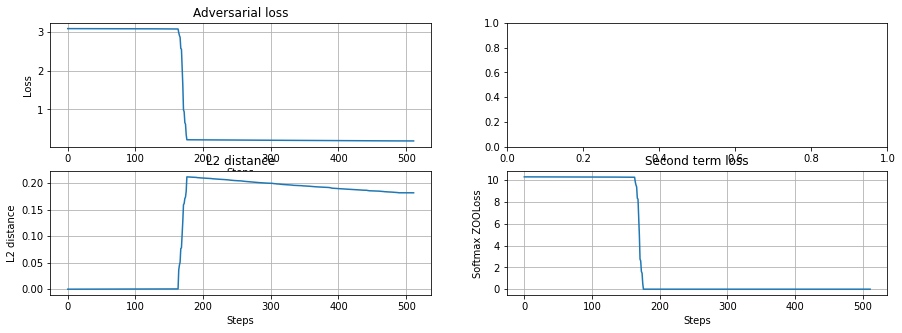

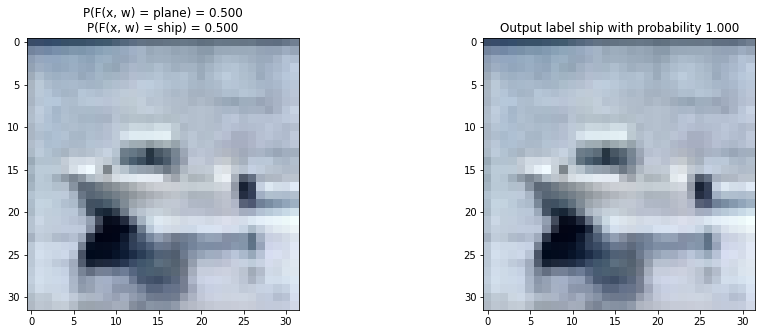

In [14]:
### Define our custom loss function and call the optimizer
adv_loss = customLoss.ZooLoss(neuron=original_label, maximise=0, is_softmax=False, dim=1)
adv_optimizer = ZOOptim.ZOOptim(model=net, loss=adv_loss, device='cuda')

### Run the optimizer
x, loss, l2_dist, losses_st, outs = adv_optimizer.run(**params)

#(X[index], c=0.5, learning_rate=0.001, stop_criterion=True, solver=solver, verbose=0, max_iterations=1000, additional_out=True)


### Compute manually last output
out = nn.Softmax(dim=1)(net(x.reshape(1, *list(img.shape))))
label = torch.argmax(out).item()
img = x.detach().cpu().numpy()

### Display results
fig, ax = plt.subplots(2, 2, figsize=(15, 5))
ax[0,0].plot(loss)
ax[0,0].set_title('Adversarial loss')
ax[0,0].set_ylabel('Loss')
ax[0,0].set_xlabel('Steps')
ax[0,0].grid()
ax[1,0].plot(l2_dist)
ax[1,0].set_title('L2 distance')
ax[1,0].set_ylabel('L2 distance')
ax[1,0].set_xlabel('Steps')
ax[1,0].grid()
ax[1,1].plot(losses_st)
ax[1,1].set_title('Second term loss')
ax[1,1].set_ylabel('Softmax ZOOLoss')
ax[1,1].set_xlabel('Steps')
ax[1,1].grid()
plt.show

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(np.transpose(img_orig, (1, 2, 0)))
ax[0].set_title('P(F(x, w) = {}) = {:.3f}\nP(F(x, w) = {}) = {:.3f}'.format(DataLoader.classes[label], float(out[0, label]),
                                                                             DataLoader.classes[original_label], float(out[0, original_label])))
ax[1].imshow(np.transpose(img_orig, (1, 2, 0)))
original_label = torch.argmax(out_orig)
ax[1].set_title('Output label {} with probability {:.3f}'.format(DataLoader.classes[original_label], float(out_orig[0, original_label])))
plt.show()

**5.2 Specific attack**

Here we try to manipulate the input such that it will be misclassified in favor of a *specific* class.

*E.g.* <br> 
We want to try to maximise the probability of classification of neuron *three*


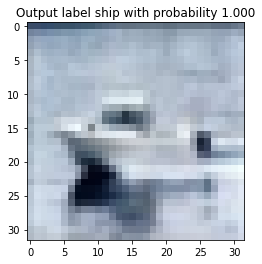

In [12]:
# 1. Choose image
index = 2

# 2. Define params
#solver = "adam"
solver = "newton"

params = {'x': X[index], 'c': 0.3, 'learning_rate': 1e-2, 
          'n_gradient': 128, 'solver': solver, 'max_steps': 1000, 
          'verbose': 0, 'stop_criterion': True, 'additional_out': True}

net.eval()
img_orig = X[index].cpu().numpy()
out_orig = nn.Softmax(dim=1)(net(X[index].reshape(1, *list(img.shape))))
plt.imshow(np.transpose(img_orig, (1, 2, 0)))
original_label = torch.argmax(out_orig).item()
plt.title('Output label {} with probability {:.3f}'.format(DataLoader.classes[original_label], float(out_orig[0, original_label])))
plt.show()




  0%|          | 0/1000 [00:00<?, ?it/s]


  0%|          | 1/1000 [00:00<02:25,  6.88it/s]


  0%|          | 2/1000 [00:00<02:25,  6.86it/s]


  0%|          | 3/1000 [00:00<02:25,  6.86it/s]


  0%|          | 4/1000 [00:00<02:26,  6.81it/s]


  0%|          | 5/1000 [00:00<02:26,  6.79it/s]


  1%|          | 6/1000 [00:00<02:26,  6.77it/s]


  1%|          | 7/1000 [00:01<02:27,  6.73it/s]


  1%|          | 8/1000 [00:01<02:26,  6.76it/s]


  1%|          | 9/1000 [00:01<02:26,  6.75it/s]


  1%|          | 10/1000 [00:01<02:25,  6.79it/s]


  1%|          | 11/1000 [00:01<02:26,  6.75it/s]


  1%|          | 12/1000 [00:01<02:27,  6.71it/s]


  1%|▏         | 13/1000 [00:01<02:27,  6.70it/s]


  1%|▏         | 14/1000 [00:02<02:26,  6.71it/s]


  2%|▏         | 15/1000 [00:02<02:26,  6.72it/s]


  2%|▏         | 16/1000 [00:02<02:25,  6.74it/s]


  2%|▏         | 17/1000 [00:02<02:25,  6.75it/s]


  2%|▏         | 18/1000 [00:02<02:26,  6.72it/s]


  2%|▏         | 19/1000 [0

First valid image found at iteration 460 with l2-distance = 0.5508658289909363





 46%|████▋     | 463/1000 [01:09<01:21,  6.61it/s]


 46%|████▋     | 464/1000 [01:09<01:20,  6.64it/s]


 46%|████▋     | 465/1000 [01:09<01:20,  6.66it/s]


 47%|████▋     | 466/1000 [01:09<01:19,  6.69it/s]


 47%|████▋     | 467/1000 [01:09<01:19,  6.70it/s]


 47%|████▋     | 468/1000 [01:09<01:19,  6.70it/s]


 47%|████▋     | 469/1000 [01:10<01:19,  6.66it/s]


 47%|████▋     | 470/1000 [01:10<01:19,  6.64it/s]


 47%|████▋     | 471/1000 [01:10<01:19,  6.66it/s]


 47%|████▋     | 472/1000 [01:10<01:18,  6.70it/s]


 47%|████▋     | 473/1000 [01:10<01:18,  6.73it/s]


 47%|████▋     | 474/1000 [01:10<01:17,  6.76it/s]


 48%|████▊     | 475/1000 [01:10<01:17,  6.75it/s]


 48%|████▊     | 476/1000 [01:11<01:17,  6.74it/s]


 48%|████▊     | 477/1000 [01:11<01:18,  6.64it/s]


 48%|████▊     | 478/1000 [01:11<01:18,  6.66it/s]


 48%|████▊     | 479/1000 [01:11<01:18,  6.68it/s]


 48%|████▊     | 480/1000 [01:11<01:17,  6.72it/s]


 48%|████▊     | 481/1000 [01:11<01:17,  6.

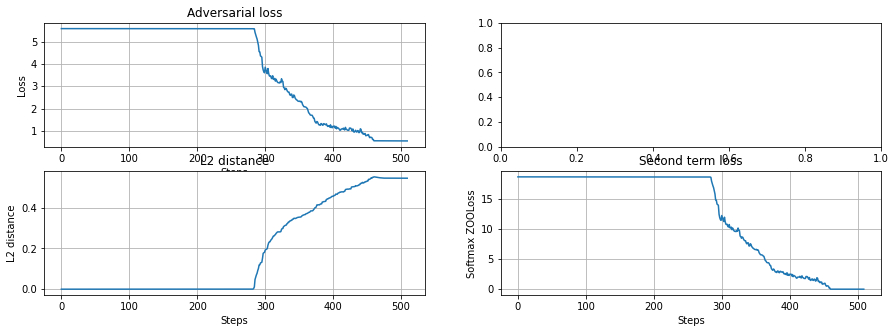

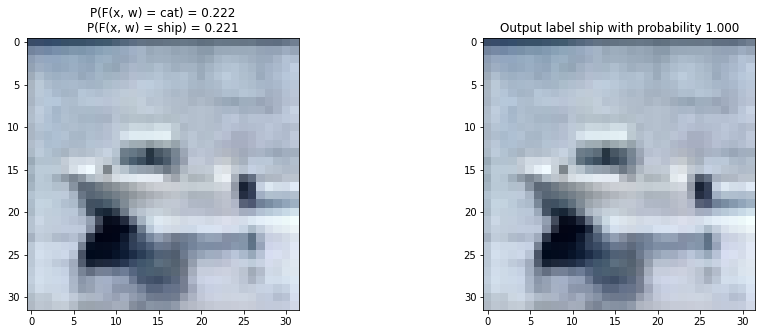

In [15]:
### Define our custom loss function and call the optimizer
adv_loss = customLoss.ZooLoss(neuron=3, maximise=1, is_softmax=False, dim=1)
adv_optimizer = ZOOptim.ZOOptim(model=net, loss=adv_loss, device='cuda')

### Run the optimizer
x, loss, l2_dist, losses_st, outs = adv_optimizer.run(**params)


### Compute manually last output
out = nn.Softmax(dim=1)(net(x.reshape(1, *list(img.shape))))
label = torch.argmax(out).item()
img = x.detach().cpu().numpy()

### Display results
fig, ax = plt.subplots(2, 2, figsize=(15, 5))
ax[0,0].plot(loss)
ax[0,0].set_title('Adversarial loss')
ax[0,0].set_ylabel('Loss')
ax[0,0].set_xlabel('Steps')
ax[0,0].grid()
ax[1,0].plot(l2_dist)
ax[1,0].set_title('L2 distance')
ax[1,0].set_ylabel('L2 distance')
ax[1,0].set_xlabel('Steps')
ax[1,0].grid()
ax[1,1].plot(losses_st)
ax[1,1].set_title('Second term loss')
ax[1,1].set_ylabel('Softmax ZOOLoss')
ax[1,1].set_xlabel('Steps')
ax[1,1].grid()
plt.show

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(np.transpose(img_orig, (1, 2, 0)))
ax[0].set_title('P(F(x, w) = {}) = {:.3f}\nP(F(x, w) = {}) = {:.3f}'.format(DataLoader.classes[label], float(out[0, label]),
                                                                             DataLoader.classes[original_label], float(out[0, original_label])))
ax[1].imshow(np.transpose(img_orig, (1, 2, 0)))
original_label = torch.argmax(out_orig)
ax[1].set_title('Output label {} with probability {:.3f}'.format(DataLoader.classes[original_label], float(out_orig[0, original_label])))
plt.show()